## Bayesian estimation of enzyme elasticities for an in vitro pathway

This notebook is focused on re-creating results from one of the initial papers on linlog kinetics [1]. In this study, data from a simple *in vitro* pathway is used to determine the enzyme elasticity matrix. The model contains 2 internal metabolites and 2 externally controlled metabolite concentrations.

In the original study [2], the authors measure concentrations of the internal metabolites and determine total steady-state flux for 19 different conditions (which vary enzyme loading, $\hat{e}$, and external concentrations $y$). 

In the previous linlog estimation, the authors use multiple linear regression to maximize the $R^2$ value of
$$ \hat{v} = \hat{e} (1 + e_x * \chi + e_y * \gamma) $$
by varying the elasticity matrices $e_x$ and $e_y$ for *measured* values of the fluxes, $v$, and internal and external metabolite concentrations ($\chi$ and $\gamma$, respectively). However, this method doesn't gaurentee you that for a chosen elasticity matrix, your steady state fluxes and concentrations are as close as possible to the measured values. Instead they are fit on a reaction-by-reaction basis.This is probably not a huge issue for smaller models such as this one, but will certainly be a source of error in larger models. Also, it prevents you from fitting any distributions when certain experimental measurements are missing.


1.	L. Wu, W. Wang, W. A. van Winden, W. M. van Gulik, J. J. Heijnen, *European Journal of Biochemistry*. 271, 3348–3359 (2004).
2.	C. Giersch, *European Journal of Biochemistry*. 227, 194–201 (1995).

In [5]:
import numpy as np
np.random.seed(0)

import pandas as pd
import scipy

import pymc3 as pm
import theano
import theano.tensor as T
floatX = theano.config.floatX

%matplotlib inline

In [6]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

Here we construct the model using the `cobrapy` package, to get the stochiometric matrix from the list of reactions

In [7]:
import cobra

model = cobra.Model()

model.add_metabolites([
        cobra.Metabolite('2pg'),
        cobra.Metabolite('pep'),
        ])

model.add_reactions([
        cobra.Reaction('PGM'),
        cobra.Reaction('ENO'),
        cobra.Reaction('PK'),
    ])

model.reactions.PGM.reaction = '<=> 2pg'
model.reactions.ENO.reaction = '2pg <=> pep'
model.reactions.PK.reaction = 'pep <=>'

N = cobra.util.create_stoichiometric_matrix(model, dtype='int')

Load experimental data from a CSV file

In [8]:
giersch = pd.read_csv('giersch.csv').astype(float)
n_exp = len(giersch)
giersch.head()

,PGM,ENO,PK,2PG,PEP,BPG,ADP,Flux
0,31.0,5.6,46.0,170.0,50.0,13.2,107.0,157.0
1,25.0,12.0,30.0,60.0,103.0,13.2,61.0,87.0
2,25.0,12.0,30.0,57.0,91.0,13.2,83.0,114.0
3,25.0,12.0,30.0,55.0,83.0,13.2,107.0,128.0
4,25.0,12.0,30.0,54.0,76.0,13.2,130.0,136.0


Here we chop up the experimental data into the e, y, v, and x vectors; and normalize them to the reference state (we use the one with the highest R2 in the original fit [2])

In [9]:
e = giersch.loc[:, ['PGM', 'ENO', 'PK']]
y = giersch.loc[:, ['BPG', 'ADP']]
v = giersch.loc[:, ['Flux']]
x = giersch.loc[:, ['2PG', 'PEP']]

ref_ind = 1

v_star = v.iloc[ref_ind].values * np.ones(3)
x_star = x.iloc[ref_ind].values
y_star = y.iloc[ref_ind].values
e_star = e.iloc[ref_ind].values

# Normalize to reference values (and drop trivial measurement)
en = e.values / e_star
yn = np.log(y.values / y_star)
xn = np.log(x.values / x_star)
vn = v.values / v_star[0]

In [10]:
n_exp

19

Here we initialize the `LinLogModel` object, which holds some convienience routines. We just use default values for the elasticity matricies.

In [11]:
import emll
Ex = emll.create_elasticity_matrix(model)

Ey = np.zeros((3, 2))
Ey[0, 0] = 1  # bpg (+) PGM
Ey[2, 1] = 1  # adp (+) PK

ll = emll.LinLogSymbolic2x2(N, Ex, Ey, v_star)

## Specify the full probability model

This is the real meat of the inference problem, where we specify the full probability model for our elasticity matricies and observed steady-state responses.

In [12]:
N.shape

(2, 3)

Text(0, 0.5, 'Probability density')

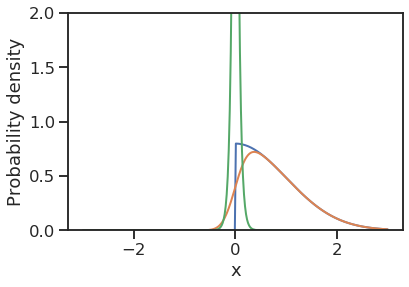

In [13]:
normal_dist = pm.HalfNormal.dist(sd=1)
t_dist = pm.SkewNormal.dist(mu=0, sd=1, alpha=5)
s_dist = pm.Laplace.dist(mu=0, b=0.05)

x_eval = np.linspace(-3, 3, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), lw=2.)
plt.plot(x_eval, theano.tensor.exp(s_dist.logp(x_eval)).eval(), lw=2.)

plt.ylim([0, 2])

plt.xlabel('x')
plt.ylabel('Probability density')

Here's the actual sampling code. First we add our prior distributions on the elasticity matrices and sample the prior predictive distribution. We use the convienence function 'initialize_elasticity' to create the relevant matrix.

In [14]:
from emll.util import initialize_elasticity

print(initialize_elasticity.__doc__)

 Initialize the elasticity matrix, adjusting priors to account for
    reaction stoichiometry. Uses `SkewNormal(mu=0, sd=sd, alpha=sign*alpha)`
    for reactions in which a metabolite participates, and a `Laplace(mu=0,
    b=b)` for off-target regulation. 

    Also accepts compartments for metabolites and reactions. If given,
    metabolites are only given regulatory priors if they come from the same
    compartment as the reaction.
    
    Parameters

    N : np.ndarray
        A (nm x nr) stoichiometric matrix for the given reactions and metabolites
    name : string
        A name to be used for the returned pymc3 probabilities
    b : float
        Hyperprior to use for the Laplace distributions on regulatory interactions
    alpha : float
        Hyperprior to use for the SkewNormal distributions. As alpha ->
        infinity, these priors begin to resemble half-normal distributions.
    sd : float
        Scale parameter for the SkewNormal distribution.
    m_compartments : lis

In [15]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', initialize_elasticity(N, 'ex', b=0.05, sd=1, alpha=5))
    Ey_t = pm.Deterministic('Ey', initialize_elasticity(-Ey.T, 'ey', b=0.05, sd=1, alpha=5))
    
with pymc_model:
    trace_prior = pm.sample_prior_predictive()

In [16]:
with pymc_model:
        
    # Error priors. 
    v_err = pm.HalfNormal('v_error', sd=0.05, testval=.1)
    x_err = pm.HalfNormal('x_error', sd=0.05, shape=2, testval=.1)

    # Calculate steady-state concentrations and fluxes from elasticities
    chi_ss, v_hat_ss = ll.steady_state_theano(Ex_t, Ey_t, en, yn)

    # Error distributions for observed steady-state concentrations and fluxes
    chi_obs = pm.Normal('chi_obs', mu=chi_ss, sd=x_err, observed=xn)
    v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss[:, 0].squeeze(),
                          sd=v_err, observed=vn.squeeze())

print(pymc_model.logpt.tag.test_value)

-555.901251893345


This is the actual computationally intensive portion, where we sample the posterior distribution using hamiltonian monte carlo.

In [17]:
with pymc_model:
    trace = pm.sample(500, random_seed=123, tune=1000,
                      init='nuts', n_init=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_error, v_error, ey_capacity_entries, ey_kinetic_entries, ex_capacity_entries, ex_kinetic_entries]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [01:05<00:00, 92.11draws/s] 
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_error, v_error, ey_capacity_entries, ey_kinetic_entries, ex_capacity_entries, ex_kinetic_entries]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [07:06<00:00, 14.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


If desired, the trace object can be pickled for later use

In [18]:
# import gzip
# import pickle

# with gzip.open('data/wu_trace.pgz', 'wb') as f:
#     pickle.dump(trace, f)

In [19]:
# Values for wu 'optimized elasticity' from the same reference state
e_wu = np.array([-0.55 , -1.30 , 1.53 , 0 , 0.76 , -3.10 ,
                 1.86 , 0 , -0.25 , 0 , 0.54 , 0.70]).reshape((3, -1))

ex_wu = e_wu[:, :2]
ey_wu = e_wu[:, 2:]

/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38 UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38 UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38 UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38 UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38 UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/opt/conda/lib/python3.7/site-packages/arviz/plots

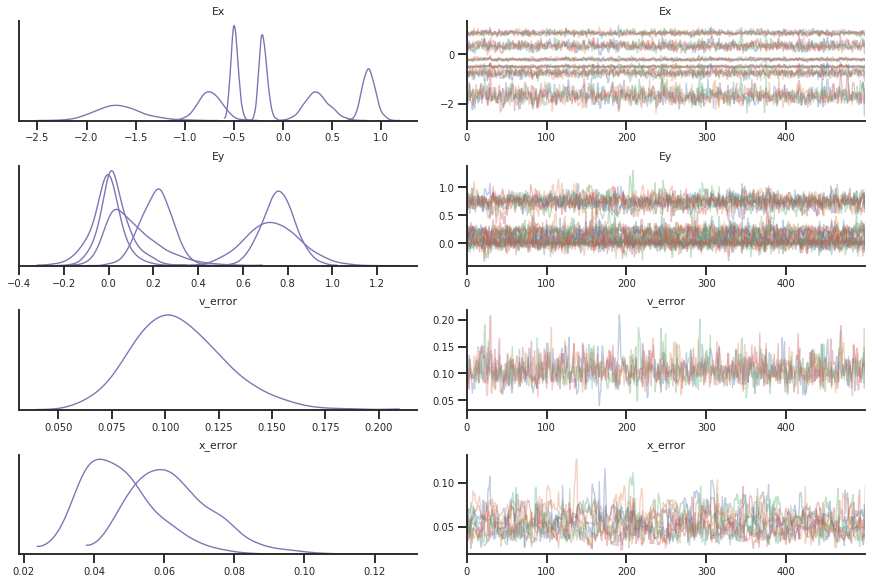

In [20]:
tp = pm.traceplot(trace, var_names=['Ex', 'Ey', 'v_error', 'x_error'], combined=True,
                  lines={'Ex': ex_wu.T.flatten(), 'Ey': ey_wu.T.flatten()})
sns.despine()

for ax in tp.flatten():
    ax.set_rasterized(True)

# plt.savefig('wu_trace.svg', dpi=100, transparent=True)

In [21]:
ex = trace['Ex'].reshape((2000, -1))
ey = trace['Ey'].reshape((2000, -1))
e_all = np.hstack([ex, ey])

In [22]:
m_labels = [m.id for m in model.metabolites]
r_labels = [r.id for r in model.reactions]
y_labels = ['BPG', 'ADP']

ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                       for mlabel in m_labels] for rlabel in r_labels]).flatten()
ey_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                       for mlabel in y_labels] for rlabel in r_labels]).flatten()

e_labels = np.hstack((ex_labels, ey_labels))

In [23]:
import scipy.stats

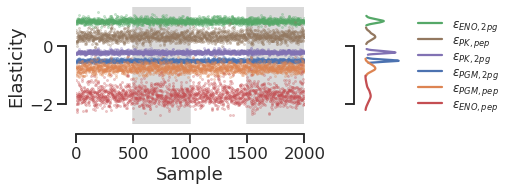

In [36]:
fig = plt.figure(figsize=(6,3))

ax = plt.subplot2grid((1, 4), (0, 0), colspan=3)

ax.plot(ex, '.', ms=4, alpha=.25, rasterized=True)
ax.axvspan(500, 1000, zorder=0, color='.85')
ax.axvspan(1500, 2000, zorder=0, color='.85')
ax.set_xlim([0, 2000])


sns.despine(trim=True, offset=10, ax=ax)
ax.set_ylabel('Elasticity')
ax.set_xlabel('Sample')

ax2 = plt.subplot2grid((1, 4), (0, 3), colspan=1, fig=fig, sharey=ax)
ax2.xaxis.set_visible(False)
sns.despine(trim=True, offset=10, ax=ax2, bottom=True)


colors = sns.color_palette()
for i in ex.mean(0).argsort()[::-1]:
    xs = np.linspace(np.percentile(ex[:, i], 1), np.percentile(ex[:, i], 99), 200)    
    kernel = scipy.stats.gaussian_kde(ex[:, i])
    ax2.plot(kernel(xs), xs, label=e_labels[i], color=colors[i])

plt.setp(ax2.get_yticklabels(), visible=False)
plt.tight_layout()
    
ax2.legend(loc='center left', fontsize=12, bbox_to_anchor=(1.2, .5), labelspacing=0)
    
# plt.savefig('wu_trace_subset.svg', dpi=200)

In [37]:
pm.hpd(trace['ey_kinetic_entries'])

array([[0.49533357, 0.95720791],
       [0.6160652 , 0.89200898]])

In [38]:
pm.hpd(trace['ey_capacity_entries'])

array([[ 0.07771261,  0.33995626],
       [-0.06222609,  0.35788854],
       [-0.10102182,  0.17886091],
       [-0.14660631,  0.14226407]])

In [39]:
e_df = pd.DataFrame(e_all, columns=e_labels)
e_df.apply(pm.hpd)

,"$\epsilon_{PGM,2pg}$","$\epsilon_{PGM,pep}$","$\epsilon_{ENO,2pg}$","$\epsilon_{ENO,pep}$","$\epsilon_{PK,2pg}$","$\epsilon_{PK,pep}$","$\epsilon_{PGM,BPG}$","$\epsilon_{PGM,ADP}$","$\epsilon_{ENO,BPG}$","$\epsilon_{ENO,ADP}$","$\epsilon_{PK,BPG}$","$\epsilon_{PK,ADP}$"
0,-0.559841,-0.958076,0.741235,-2.099498,-0.273160,0.111337,0.495334,0.077713,-0.062226,-0.101022,-0.146606,0.616065
1,-0.420294,-0.511584,0.995098,-1.208423,-0.122088,0.583821,0.957208,0.339956,0.357889,0.178861,0.142264,0.892009


(0.1, 11.9)

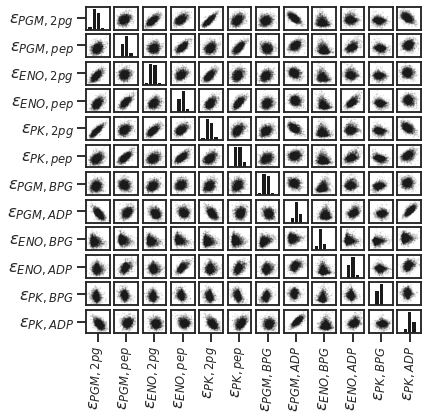

In [40]:
fig, axmatrix = plt.subplots(nrows=12, ncols=12, figsize=(6, 6))

for ax in axmatrix.flatten():
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

for i in range(12):
    for j in range(12):
        if i is not j:
            axmatrix[i,j].plot(e_all[:, i], e_all[:, j],
                               'k.', alpha=0.1, ms=1, rasterized=True)
        else:
            axmatrix[i,j].hist(e_all[:, i], bins=5, color='k', edgecolor='w', lw=1)
            
_ = ax_all = fig.add_subplot(111, frameon=False)
_ = ax_all.set_xticks(np.arange(12) + 0.5)
_ = ax_all.set_xticklabels(e_labels, rotation=90)
_ = ax_all.set_yticks(np.arange(12) + 0.5)
_ = ax_all.set_yticklabels(e_labels[::-1])

ax_all.set_xlim([0.1, 11.9])
ax_all.set_ylim([0.1, 11.9])

# fig.savefig('elasticity_pairplot.svg', dpi=400, transparent=True)

In [41]:
with pymc_model:
    ppc = pm.sample_ppc(trace, samples=1000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2 DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247 UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
100%|██████████| 1000/1000 [00:08<00:00, 122.12it/s]


## Equivalent approach using variational inference

Here we approximate the posterior distribution using ADVI to compare the two methods.

In [42]:
with pymc_model:
    approx = pm.ADVI()
    hist = approx.fit(n=25000, obj_optimizer=pm.adagrad_window(learning_rate=5E-3),
                      obj_n_mc=1)
    
with pymc_model:
    trace_vi = hist.sample(1000)
    ppc_vi = pm.sample_ppc(trace_vi, samples=1000)

Average Loss = -24.292: 100%|██████████| 25000/25000 [00:30<00:00, 817.85it/s]
Finished [100%]: Average Loss = -24.309
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8 DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
100%|██████████| 1000/1000 [00:05<00:00, 195.17it/s]


ADVI is an optimization-based method, so we monitor the evidence lower bound to check convergence

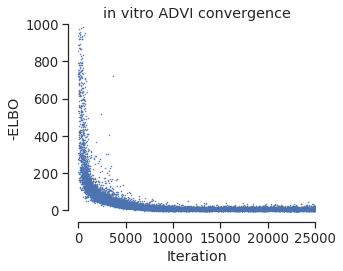

In [43]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4))
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.ylim([-1E1, 1E3])
    plt.xlim([0, 25000])
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('in vitro ADVI convergence')
    plt.tight_layout()
    # plt.savefig('wu_elbo.svg', transparent=True, dpi=200)

In [44]:
x = giersch.loc[:, ['2PG', 'PEP']]

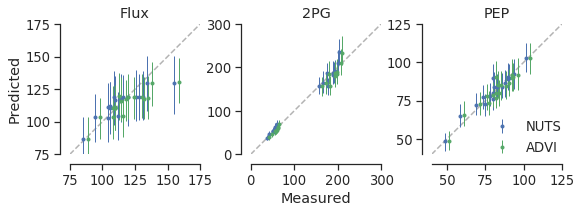

In [45]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig, axmatrix = plt.subplots(ncols=3, figsize=(8,3.5))

    for ax in axmatrix.flatten():
        ax.set_aspect('equal')

    def plot_hpd_err(truth, ppc, ax, color=None):
        median = np.median(ppc, 0)
        hpd = pm.hpd(ppc)
        err = np.abs(hpd - median[:, np.newaxis])

        return ax.errorbar(truth, median, yerr=err.T, ls='',
                           marker='.', elinewidth=1., color=color)

    plot_hpd_err(vn * v_star[0] - 2, ppc['v_hat_obs'] * v_star[0], axmatrix[0])
    plot_hpd_err(x['2PG'].values - 3, x_star[0] * np.exp(ppc['chi_obs'][:,:,0]),
                 axmatrix[1])
    l0 = plot_hpd_err(x['PEP'].values - 1.25, x_star[1] * np.exp(ppc['chi_obs'][:,:,1]),
                      axmatrix[2])

    plot_hpd_err(vn * v_star[0] + 2, ppc_vi['v_hat_obs'] * v_star[0], axmatrix[0], 'g')
    plot_hpd_err(x['2PG'].values + 3, x_star[0] * np.exp(ppc_vi['chi_obs'][:,:,0]),
                 axmatrix[1], 'g')
    l1 = plot_hpd_err(x['PEP'].values + 1.25, x_star[1] * np.exp(ppc_vi['chi_obs'][:,:,1]),
                      axmatrix[2], 'g')

    axmatrix[0].set_title('Flux')
    axmatrix[1].set_title('2PG')
    axmatrix[2].set_title('PEP')
    # axmatrix[3].set_title('Enzymes')

    axmatrix[1].set_xlabel('Measured')
    axmatrix[0].set_ylabel('Predicted')

    fig.tight_layout()

    ax0 = [75, 175]
    ax2 = [40, 125]
    
    axmatrix[0].set_xlim(*ax0)
    axmatrix[0].set_ylim(ax0)
    axmatrix[0].plot(ax0, ax0, '--', color='.7', zorder=0)

    axmatrix[1].set_xlim([0, 300])
    axmatrix[1].set_ylim([0, 300])
    axmatrix[1].plot([0, 300], [0, 300], '--', color='.7', zorder=0)

    axmatrix[2].set_xlim(*ax2)
    axmatrix[2].set_ylim(*ax2)
    axmatrix[2].plot(ax2, ax2, '--', color='.7', zorder=0)

    # axmatrix[3].plot([0, 60], [0, 60], '--', color='.7', zorder=0)

    axmatrix[0].set_yticks(np.arange(75, 200, 25))
    axmatrix[0].set_xticks(np.arange(75, 200, 25))

    axmatrix[1].set_yticks(np.arange(0, 350, 100))
    axmatrix[1].set_xticks(np.arange(0, 350, 100))

    axmatrix[2].set_yticks(np.arange(50, 150, 25))
    axmatrix[2].set_xticks(np.arange(50, 150, 25))

    leg = plt.legend([l0, l1], ['NUTS', 'ADVI'],
                     loc='lower right', borderpad=0, borderaxespad=0)

    sns.despine(trim=False, offset=10)
    # fig.savefig('ppc_predictions.svg')

In [46]:
ex = trace['Ex'].reshape((2000, -1))
ey = trace['Ey'].reshape((2000, -1))
e_all = np.hstack([ex, ey])

Here we calculate the flux control coefficients for both the ADVI and NUTS posteriors

In [47]:
fcc = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace['Ex']])
fcc_mb = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_vi['Ex']])
fcc_prior = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_prior['Ex']])

In [48]:
# Control coefficients estimated from elasticities
# Wu table 7

wu_ccs = np.array([-0.34 , 0.14 , 1.20])

In [49]:
df1 = pd.DataFrame(fcc[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)
df2 = pd.DataFrame(fcc_mb[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)
df3 = pd.DataFrame(fcc_prior[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)

df1['type'] = 'NUTS'
df2['type'] = 'ADVI'
df3['type'] = 'Prior'


fcc_df = pd.concat([df1, df2, df3])
fcc_df.columns = ['Reaction', 'FCC', 'Type']

fcc_df.loc[fcc_df.FCC < -.5, 'FCC'] = np.nan
fcc_df.loc[fcc_df.FCC > 1.5, 'FCC'] = np.nan

In [50]:
ax.patches

[]

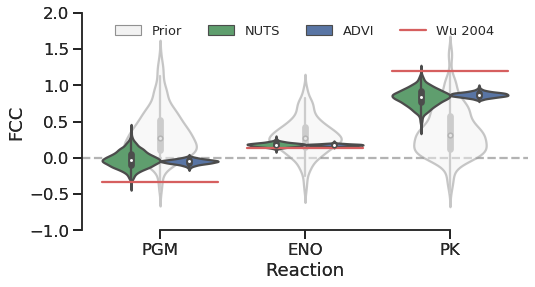

In [51]:
fig = plt.figure(figsize=(8, 4))

my_pal = {"Prior": ".8", "NUTS": "g", "ADVI":"b"}

ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frameon=False, sharex=ax, sharey=ax)

sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=fcc_df[fcc_df.Type == 'Prior'],
    scale='width', width=0.5, legend=False, zorder=0,
    color='1.', ax=ax, saturation=1., alpha=0.01)

plt.setp(ax.lines, color='.8')
plt.setp(ax.collections, alpha=.5, label="")


sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=fcc_df,
    scale='width', width=0.8, hue_order=['NUTS', 'ADVI'],
    legend=False, palette=my_pal, zorder=3, ax=ax2)

for i, cc in enumerate(wu_ccs):
    l = plt.plot([i - .4, i + .4], [cc, cc], '-', color=sns.color_palette('muted')[3])

phandles, plabels = ax.get_legend_handles_labels()
handles, labels = ax2.get_legend_handles_labels()
ax.legend().remove()
ax2.legend().remove()

ax2.legend(phandles + handles + l, plabels + labels + ['Wu 2004'], loc='upper center', ncol=4, fontsize=13)
ax.set_ylim([-1, 2])

ax.axhline(0, ls='--', color='.7', zorder=0)
sns.despine(trim=True)

fig.savefig('wu_fccs.svg', transparent=True)

In [52]:
ex_vi = trace_vi['Ex'].reshape((len(trace_vi), -1))
ey_vi = trace_vi['Ey'].reshape((len(trace_vi), -1))
e_all_vi = np.hstack([ex_vi, ey_vi])

e_df_vi = pd.DataFrame(e_all_vi, columns=e_labels)
e_df_vi.apply(pm.hpd)

,"$\epsilon_{PGM,2pg}$","$\epsilon_{PGM,pep}$","$\epsilon_{ENO,2pg}$","$\epsilon_{ENO,pep}$","$\epsilon_{PK,2pg}$","$\epsilon_{PK,pep}$","$\epsilon_{PGM,BPG}$","$\epsilon_{PGM,ADP}$","$\epsilon_{ENO,BPG}$","$\epsilon_{ENO,ADP}$","$\epsilon_{PK,BPG}$","$\epsilon_{PK,ADP}$"
0,-0.526344,-0.851600,0.809341,-1.917831,-0.244742,0.239671,0.553965,0.176589,-0.087005,-0.057950,-0.099949,0.704066
1,-0.468464,-0.702844,0.959647,-1.545882,-0.179218,0.392747,0.857284,0.254981,0.238314,0.082337,0.087663,0.796138


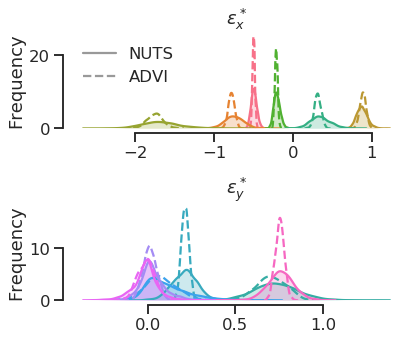

In [60]:
colors = sns.color_palette('husl', n_colors=e_all_vi.shape[-1])

fig, axmatrix = plt.subplots(nrows=2, sharex=False, figsize=(6,5))

for i, color in enumerate(colors[:6]):
    sns.kdeplot(ex[:, i], shade=True, color=color, ax=axmatrix[0])
    sns.kdeplot(ex_vi[:, i], ls='--', color=color, ax=axmatrix[0])

for i, color in enumerate(colors[6:]):
    sns.kdeplot(ey[:, i], color=color, shade=True,
               ax=axmatrix[1])
    sns.kdeplot(ey_vi[:, i], ls='--', color=color,
               ax=axmatrix[1])

import matplotlib.lines as mlines
hmc_line = mlines.Line2D([], [], color='.6', ls='-', label='NUTS')
vi_line = mlines.Line2D([], [], color='.6', ls='--', label='ADVI')

axmatrix[0].set_ylabel('Frequency')
axmatrix[1].set_ylabel('Frequency')

axmatrix[0].set_title('$\epsilon_x^*$')
axmatrix[1].set_title('$\epsilon_y^*$')

axmatrix[0].legend(handles=[hmc_line, vi_line], loc='upper left')
plt.tight_layout()
sns.despine(trim=True, offset=5)
# fig.savefig('advi_nuts_elasticity.svg', transparent=True)